# How to Price & Sell Your Home
## A data exploration, modeling and evaluation using the Ames, Iowa housing sales dataset

### Overview

- Initial exploration
    - Exploration of the target variable
- Data preparation
- Modeling
    - Model-less baseline
    - Multiple linear regression
    - Ridge regression
- Discussion of next steps


Selling a home can be a torturous process. Homeowners rely on real estate agent's opinions and experience to guide them to the right decisions. So many questions haunt the homeowner. Are you pricing it right for the market? Are you pricing it to move quickly or get the maximum price?

My project aims to predict the sale price of houses using the [Ames, Iowa housing dataset](http://jse.amstat.org/v19n3/decock.pdf) produced by Dean De Cook, of Truman University in 2011. The training dataset used for this anaylsis was sourced from the [Advanced Regression Techniques Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). 

I began with a baseline that predicts only the mean house price from the training data for each house, but this model does very poorly (of course). My final model is a Ridge regression model, which had an R2 Score of 0.89 and a MAE on the test data of $18,011.

### Data Overview

The subset of the Ames, Iowa dataset includes 1,460 home sales and record 81 variables for each home. The variables describe the details of the home, its ammenities, the lot, the zoning, and descriptors of the type of sale itself. While many variables are not within the control of the homeowner, such as lot size or zoning, including them in the eventual model will be useful for controlling for the impact. 

A [full description of the original variables](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=data_description.txt) in the dataset is available. The final version of the dataset _before_ train-test-split has 1,294 observations and 43 numeric variables.

For this introductory analysis, I converted many variables to binary encoding, including some variables that were discrete, such as "number of fireplaces" became "Has Fireplace". A few categorical variables, rather than being one hot encoded into numerous binary columns, were reduced downn to the most popular category vs not. For  example, the categorical variable "electrical" was converted to is the house has a switch board breaker box vs anything  else. 

Future analysis  will include expanding the feature  set to include  more of the categorical variables.

The resulting dataset is a mixture of continuous, ordinal, and binary variables with no missing observations. 

In [2]:
# Imports
import pandas as pd
import numpy as np

# Custom code
import code.data_prep_code as dpc
import code.visuals_code as vc

# Visalization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Preparation and Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Feature importance library
import eli5
from eli5.sklearn import PermutationImportance

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Data Descisions

**Removed Observations**

I used the variable `SaleType`, to exclude new construction and estate trasfers from the analysis. I assumed that homeowners most interested in this analysis would be currently living _in_ their home and looking to sell. I then dropped the variable. Removing those home sales reduced the dataset to 1,295 observations. One house was also removed because it did not have electricity.

**Removed Variables**

- `Id` was removed, as it is a house identifier and not descriptive. 
- `FireplaceQu` was removed because the majority of houes do not have fireplaces. 
- `MiscFeature` was removed because there were so few misc features in the dataset. Sheds, second garages, and such counted as misc features.
- All variables that assessed the quality or condition of a _specific part of the house_ were dropped. Only Overall Condition and Overall Quality were retained. I mad this choice because the Overall variables are composits of the individual. If housing condition proves to be an important variable, later analysis can examine how the quality of individual rooms interact with overall quality and impact the final sale. 

**New  Variables**

- `Alley`: Only 91 homes in the dataset were listed to have `Alley`s behind the house, and the values for that variable were "gravel", "paved", or missing. I created a new variable to just capture **if** the property was adjacent to the property and drop the original alley type variable.
- `HasPool`: There are only 6 pools in the dataset. I dropped `PoolQC` and transformed `PoolArea` into `HasPool`
- `HasFireplace`: reduced `Fireplaces`, which is a count of fireplaces in the home, to a binary yes/no if the home has a fireplace at all.
- `HasFence`: reduced `Fence`, a list of fence condition descriptors, to a binary yes/no if the home came with a fence.
- `HasGarage`: if `GarageArea` equals zero, then the property has no garage. It also explains why some observations have missing variables for garage attributes. Upon investigation, those observations have zero garage area. 
- `GarageAreaPerCar`: `GarageArea` divided by `GarageCars`. With this created I could then drop `GarageArea`. It's assumed that the more cars, the larger the garage, so I did not want both variables in there violating regression assumptions. Having the ratio will control for multi-car garages that actually have very little space.
- `BsmtPerFinished`: The percent of the basement that is finished
- `HasCentralAir`: When CentralAir equals "Yes"
- `GasAirHeat`: Is set to 1 when the house uses a Gas forced warm air furnace for heating
- `SBboxElectric`: Is set to 1 when Standard Circuit Breakers & Romex is how the electrical is wired
- `HasDeck`: If the squarefootage of deck area is greater than 0
- `HasRemod`: If a renovation happened at all in house history
- `HouseAge`: They age of the house at time of sale
- `TimeSinceRemodel`: The years since the remodel
- `RemodFiveYrs`:  If the remodel happened within the 5 years prior to the sale
- `GaragebuiltWHouse`: Was the garage built at the same time as the house or later
- `AverageRoomSize`: Divided total living above ground space by total above ground room count
- `HasFinishedBsmt`: If any part of the basement is finished

**Fill NAs**

`LotFrontage`: filled the missing values with 0. The variable measures the number of feet of street the property touches. 


In [98]:
df = pd.read_csv('data/train.csv')

In [99]:
df = dpc.address_nas(df)

In [100]:
df_final = df.select_dtypes(exclude='object')

In [47]:
# Evaluating the breakdown of each numeric column
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1294.0,57.751159,42.396828,20.0,20.000000,50.000000,70.000000,190.0
LotFrontage,1294.0,55.865533,34.285307,0.0,40.000000,60.000000,78.000000,313.0
LotArea,1294.0,10485.491499,10371.422824,1300.0,7500.000000,9375.000000,11470.500000,215245.0
OverallQual,1294.0,5.976043,1.329729,1.0,5.000000,6.000000,7.000000,10.0
OverallCond,1294.0,5.636012,1.148509,1.0,5.000000,5.000000,6.000000,9.0
MasVnrArea,1294.0,93.699382,172.244583,0.0,0.000000,0.000000,145.000000,1600.0
BsmtUnfSF,1294.0,531.792117,414.005734,0.0,207.250000,448.000000,768.750000,2336.0
TotalBsmtSF,1294.0,1021.054096,401.208183,0.0,788.000000,964.500000,1232.000000,3206.0
1stFlrSF,1294.0,1133.052550,355.946808,334.0,872.000000,1057.500000,1339.750000,3228.0
2ndFlrSF,1294.0,350.793663,433.099395,0.0,0.000000,0.000000,729.000000,2065.0


#### Explore Target Variable

The _median_ price of a home sold in this data set is \$157,950.00  <br>
The _mean_ price of a home sold in this data set is \$173,294.63  <br>

While the bulk of Sale Price distribution appears fairly normal, the target variable shows that there are some outliers in the data. These higher priced homes skew the districution. I kept these outliers in, however may consider doing a transformation at some point to normalize the target variable. Alternatively, I could train my model without those outliers, with the understanding that then my model would only be accurate at homes that would be sold at prices less than a certain amount.

In [82]:
vc.dist_var_hist_box(df_final.SalePrice, "SalePrice_hist_box")
vc.dist_var_one(df_final.SalePrice, "SalePrice")

<Figure size 1280x800 with 0 Axes>

<Figure size 1280x800 with 0 Axes>

![salesprice5](./images/SalePrice_hist_box.png)

#### Explore Correlation with Target
The most correlated variable with the target is `OverallQual`, which captures the ranking of the Overall Quality of a home

In [91]:
vc.good_heat_map(df_final)

<Figure size 792x792 with 0 Axes>

![heatmapfixed5](./images/corr_heatmap.png)

In [84]:
vc.scatter_explore(df_final)

<Figure size 1280x800 with 0 Axes>

![scatter4](./images/scatter_price.png)

### Data Preparation



In [8]:
# Splitting my data into X and Y
target = ['SalePrice']


X = df_final.drop(columns=target)
y = df_final[target]

# Creating a split in my data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42)

### Modeling



#### Model-Less Baseline

I began with a baseline that predicts only the mean house price from the training data for each house, but this model does very poorly (of course). I then explored an Ordinary Least Squares Regression before ending with a Ridge regression model, which faired the best in terms of fit and prediction.

I began with a model-less baseline which simply predicts the average sale price from the training set.

In [9]:
# Create DataFrame to store results

stat_columns = ["Training R2", 'Testing R2', 'Training MAE ', 'Testing MAE']
index_stats = ["Baseline Model", "OLS Model", "Ridge Regression"]
summary_stats = pd.DataFrame(columns=stat_columns)

In [10]:
# Grabbing the target mean from the training data
y_mean_train = y_train.mean()

# Creating predictions for the train and test sets
baseline_y_pred_train = ([y_mean_train]*len(y_train))
baseline_y_pred_test = ([y_mean_train]*len(y_test))

In [11]:
# Evaluating my model-less baseline

# creating df of results
sam_list = [r2_score(y_train, baseline_y_pred_train),r2_score(y_test, baseline_y_pred_test),
        mean_absolute_error(y_train, baseline_y_pred_train), mean_absolute_error(y_test, baseline_y_pred_test) ]
test = pd.Series(sam_list, index = stat_columns)
summary_stats= summary_stats.append(test, ignore_index=True)

#### Linear Regression Model

I then used a multiple linear regression model on my 42 numeric features that I already prepared.

In [12]:
# Modeling
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicting w model
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [13]:
# Storing performance metrics
sam_list = [r2_score(y_train, y_pred_train),r2_score(y_test, y_pred_test),
        mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test) ]
test = pd.Series(sam_list, index = stat_columns)
summary_stats= summary_stats.append(test, ignore_index=True)

#### Addressing Multicolinearity

Looking at the correlation between variables in the test set, I can see that there is correlation between features. I thus use a Ridge regression model to attempt to regularize away from the effects of that multicollinearity.

In [92]:
vc.full_heat_map(X_test)

<Figure size 1760x1440 with 0 Axes>

![full_heatmap4](./images/full_heatmap.png)

### Ridge Regression Model

In [14]:
# Modeling Ridge

ridge = Ridge(random_state=42)
ridge.fit(X_train, y_train)

ridge_y_pred_train = ridge.predict(X_train)
ridge_y_pred_test = ridge.predict(X_test)

In [15]:
sam_list = [r2_score(y_train, ridge_y_pred_train),r2_score(y_test, ridge_y_pred_test),
        mean_absolute_error(y_train, ridge_y_pred_train), mean_absolute_error(y_test, ridge_y_pred_test) ]
test = pd.Series(sam_list, index = stat_columns)
summary_stats= summary_stats.append(test, ignore_index=True)

### Extracting Coefficients from Ridge Model

In [66]:
coef_dict = {}
for feat, coef in zip(X_train.columns.tolist(), ridge.coef_[0].tolist()):
    coef_dict[feat] = coef

coef_vals = pd.DataFrame(data=coef_dict, index = coef_dict.keys())
transposed_coef = coef_vals.T

report = transposed_coef[transposed_coef.columns[:1]]
report.columns = ['Coefficients']
tc.coefficient_table(report)

### Model Evaluation

#### Checking Assumptions

In [186]:
from yellowbrick.regressor import ResidualsPlot

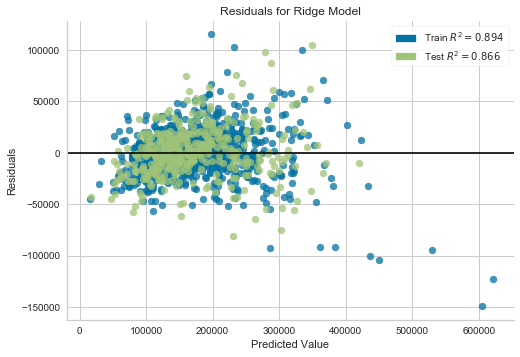

In [189]:
visualizer = ResidualsPlot(ridge, hist = False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

The outliers that showed on the earlier boxplot and scatterplot are clearly visable on the Residuals Plot. In future iterations I would remove those outliers, and state the assumption that this model is targeted to the _average_ home owner in Ames, Iowa and any home sold over \$400,000 is far above average.

I would also prioritize a deeper exploration of the model residuals in further study.

#### Checking Feature Importance

I'm using the eli5 library to do permutation importance to explore which feature was the most important to my Ridge regression model.

In [122]:
# printing the weights, aka importance, for each variable 
perm = PermutationImportance(ridge, random_state=1).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top=None)

Weight,Feature
2.0422 ± 0.2634,GrLivArea
0.6316 ± 0.0540,TotRmsAbvGrd
0.3785 ± 0.0292,AverageRoomSize
0.3780 ± 0.0564,TotalBsmtSF
0.1554 ± 0.0200,BsmtUnfSF
0.1182 ± 0.0157,OverallQual
0.1049 ± 0.0189,HouseAge
0.0702 ± 0.0030,2ndFlrSF
0.0563 ± 0.0129,BsmtPerFinished
0.0380 ± 0.0079,BedroomAbvGr


Unsurprisingly, the most important feature to my Ridge regression model is the one which is most correlated with the target: `OverallQual`

#### Evaluate and compare performance metrics across models

The Ridge Regression out performed the other model specifications with the lowest Train and Test Mean Absolute Error. While the values between the OLS and the Ridge Regression are close, I chose the Ridge model. An \\$18,000 average margin of error is much less than the initial \$52,000.

The model can give homeowners a sanity-check when comparing the attributes of their own home to how houses are selling in the market.

A window of +- //$18,000 is still substantial. "Your home will sell in this 40K range" may or may not be enough for people looking to sell their home. 

Future analysis will focus on reducing the MAE while avoiding overfitting. 

In [63]:
import code.table_code as tc

# converts summary table to image file
summary_stats.index = index_stats
tc.summary_table(summary_stats)

![summary2](./images/summary_stats.png)

#### Evaluate with model use to business question

![coeff](./images/model_coefficients.png)

#### Which home attributes are worth the most?

Controling for everything else, it seems the more recently renovated homes with extra ammenities sell for more.
- Having a fireplace
- Having a porch
- Having a deck
- Having a full bathroom in the basement
- The more cars a garage can fit the better!
- Get a pool

While `HasPool` did not show a strong correlation to `SalePrice` on its own, controlling for _all other variables_, the presence of a pool is worth \\$20K. 

The challenge with all of those add ons, is **how much does installing these add ons costs?!**

The _good_ news is that condition and quality rankings are also worth the highest amount after having a pool. This empowers a homeowner to make good choices about how they spend their money improving their home to get the most of their housing sale. \\$5000 spent making smaller fixes to improve the quality and condition of the home could have much larger returns than installing a pool. 

### Next Steps

In the future I would like to first use more of the categorical features, and perhaps encode some of the discrete features I used in my final model. There are also many interaction terms that could be added to better capture the relationship between home variables and their sales price. 

After those permutations, I would reduce my feature set to only use the most important, perhaps by regularizing using both LASSO and Ridge through an ElasticNet model. I could also only use the top 5-10 features based on Permutation Importance. 

I'd also like to explore capping my training data so that I create a model that only works on houses priced up to a certain point. This would narrow the target audience of my model, but at the same time Could make it work better on houses that are priced within a specific range. Thus, if I received a result from my model outside that range I could know that my model is likely not accurately pricing that home and thus should be handled using different techniques or models. 